<a href="https://colab.research.google.com/github/amitredd/Authentication-/blob/master/vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 9.4 MB/s 


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import os  
import matplotlib.pyplot as plt 
import cv2 
import pickle as pickle 
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()



In [3]:
data_dir = '/content/drive/MyDrive/flow'

categories = ['daisy', 'dandelion' , 'rose', 'sunflower', 'tulip']

data = []

def make_data():
    for category in categories:
        path = os.path.join(data_dir, category)
        label = categories.index(category)

        for img_name in os.listdir(path):
            image_path = os.path.join(path, img_name)
            image = cv2.imread(image_path)


            try:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, (32,32))
                image = np.array(image)

                data.append([image, label])

            except Exception as e:
                pass

    print(len(data))
    pik = open('flower.pickle','wb')
    pickle.dump(data, pik)
    pik.close()
make_data()
def load_data():
    pick  = open('flower.pickle', 'rb')
    data = pickle.load(pick)

    pick.close()

#np.random(data)

    feature = []
    labels = []

    for img, label in data:
        feature.append(img)
        labels.append(label)

    feature = np.array(feature, dtype = np.float32)
    feature = feature/ 255.

    labels = np.array(labels)

    return [feature, labels]

4308


In [4]:
feature,label = load_data()
categories = ['daisy', 'dandelion' , 'rose', 'sunflower', 'tulip']
num_classes = 5
input_shape = (32, 32, 3)

x_train, x_test, y_train, y_test = train_test_split(feature,label,test_size=0.1,shuffle=True)
train_dataset=tf.data.Dataset.from_tensor_slices((x_train,y_train)) 
x_train, x_test = tf.cast(x_train, tf.float32), tf.cast(x_test, tf.float32)
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")


x_train shape: (3877, 32, 32, 3) - y_train shape: (3877,)
x_test shape: (431, 32, 32, 3) - y_test shape: (431,)


In [5]:
learning_rate = 0.0001
weight_decay = 0.0001
batch_size = 16
num_epochs = 20
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [6]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [7]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [8]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


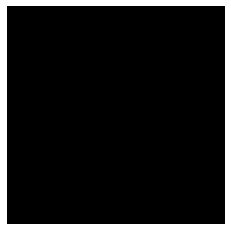

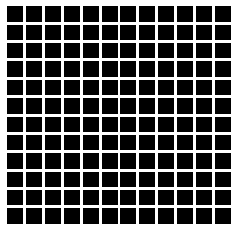

In [9]:

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [10]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [11]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


In [12]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/20
219/219 [==============================] - 33s 61ms/step - loss: 2.2795 - accuracy: 0.3236 - top-5-accuracy: 1.0000 - val_loss: 1.2827 - val_accuracy: 0.4613 - val_top-5-accuracy: 1.0000
Epoch 2/20
219/219 [==============================] - 15s 71ms/step - loss: 1.6004 - accuracy: 0.3852 - top-5-accuracy: 1.0000 - val_loss: 1.2474 - val_accuracy: 0.4665 - val_top-5-accuracy: 1.0000
Epoch 3/20
219/219 [==============================] - 14s 66ms/step - loss: 1.4123 - accuracy: 0.4311 - top-5-accuracy: 1.0000 - val_loss: 1.2236 - val_accuracy: 0.4639 - val_top-5-accuracy: 1.0000
Epoch 4/20
219/219 [==============================] - 12s 54ms/step - loss: 1.2975 - accuracy: 0.4804 - top-5-accuracy: 1.0000 - val_loss: 1.1985 - val_accuracy: 0.4845 - val_top-5-accuracy: 1.0000
Epoch 5/20
219/219 [==============================] - 11s 49ms/step - loss: 1.2084 - accuracy: 0.5168 - top-5-accuracy: 1.0000 - val_loss: 1.1186 - val_accuracy: 0.5206 - val_top-5-accuracy: 1.0000
Epoch 6/20

In [18]:
from keras.preprocessing import image
img = image.load_img('/content/drive/MyDrive/tulip.jpg', target_size=(32,32,3))

import tensorflow as tf
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions =vit_classifier.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(categories[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to tulip with a 55.63 percent confidence.
